# Forming a spread between DBS and UOB

\begin{eqnarray}
Spread_t = UOB_t +  \beta_t DBS_t \\
\end{eqnarray}

# Regress UOB against DBS to get the hedge ratio, beta

\begin{eqnarray}
UOB_t = \alpha + \beta_t DBS_t
\end{eqnarray}

In [7]:
dbs_price_array = np.array(prices['dbs_close']).reshape(-1, 1)
uob_price_array = np.array(prices['uob_close']).reshape(-1,1)

reg = LinearRegression().fit(dbs_price_array, uob_price_array)
static_hedge_ratio = reg.coef_[0][0]

print(f'The static hedge ratio is {round(static_hedge_ratio, 2)}')

The static hedge ratio is 0.98


In [8]:
spread = prices['uob_close'] - static_hedge_ratio*prices['dbs_close']

In [14]:
adf_results = adfuller(spread.values)
print('ADF Statistic: %f' % adf_results[0])
print('p-value: %f' % adf_results[1])

ADF Statistic: -2.628696
p-value: 0.087210


In [20]:
class KalmanFilterPairs():
    def __init__(self, y, f, delta, Ve):
        self.y = y # observed variable
        self.f = f # variable that is part of the observation matrix
        self.F = np.array(ts.add_constant(f))[:, [1, 0]] # observation matrix
        self.delta = delta # parameter that adjusts the sensitivity of the state update
        self.Ve = Ve # state noise variance
        
    def vectorised_filter(self):
        yhat = np.full(self.y.size, np.nan) # observed variable prediction
        e = yhat.copy() # error in observed variable prediction OR spread divergence
        Q = yhat.copy() # observed variable prediction variance OR spread divergence variance
        R = np.zeros((2,2)) # state error covariance
        P = R.copy() # state covariance update
        beta = np.full((2,self.f.size), np.nan) # state
        Vw = self.delta / (1 - self.delta) * np.eye(2) # observed variable noise variance

        beta[:, 0] = 0 # initialise beta to zero

        for t in range(self.y.size):
            if t > 0:
                beta[:, t] = beta[:, t-1] # state prediction
                R = P + Vw # state covariance prediction

            yhat[t] = np.dot(self.F[t, :], beta[:, t]) # observed variable prediction
            Q[t] = np.dot(np.dot(self.F[t, :], R), self.F[t, :].T) + self.Ve # observed variable variance prediction
            e[t] = self.y.iloc[t] - yhat[t] # observed variable prediction error

            K = np.dot(R, self.F[t, :].T) / Q[t] # Kalman gain
            beta[:, t] = beta[:, t] + np.dot(K, e[t]) # State update
            P = R - np.dot(np.outer(K, self.F[t, :]), R) # State covariance update

        # assigning
        self.mean = beta[1, :]
        self.hedge_ratio = beta[0, :]
        self.spread_divergence = e
        self.spread = self.spread_divergence + self.mean
        self.std = np.sqrt(Q)

# State Equation Noise

We can assume variance of the state transition equation is as such:

\begin{eqnarray}
V_w = \frac{\delta}{(1-\delta)} I
\end{eqnarray}

Where $\delta$ is a parameter between 0 and 1 that determines the sensitivity of ($\beta_0, \beta_1$)

In [18]:
# Initialising A Kalman Filter Algorithm

kfp = KalmanFilterPairs(y=prices['uob_close'], 
                        f=prices['dbs_close'], 
                        delta=0.0001, 
                        Ve=0.1)

In [21]:
kfp.vectorised_filter()

In [31]:
static_spread = prices['uob_close'] - static_hedge_ratio*prices['dbs_close']

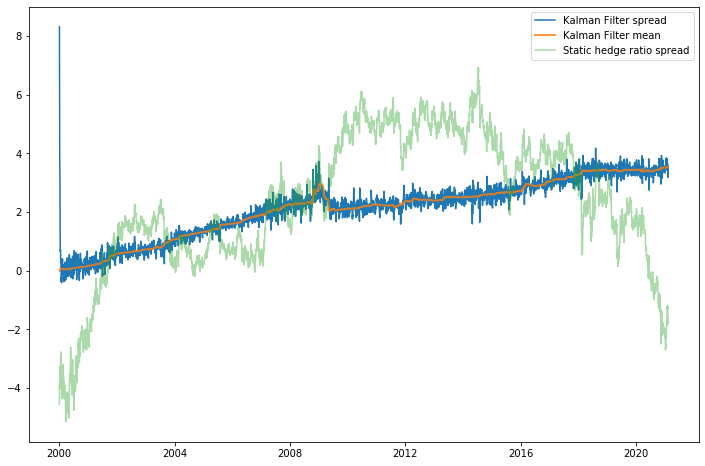

In [54]:
plt.plot(prices.index, kfp.spread, label='Kalman Filter spread')
plt.plot(prices.index, kfp.mean, label='Kalman Filter mean', linewidth=2, alpha=0.8)

plt.plot(prices.index, static_spread, label='Static hedge ratio spread', alpha=0.4)
plt.legend()
plt.show()

In [55]:
signals = pd.DataFrame({'kalman_spread': kfp.spread,
                        'kalman_mean': kfp.mean,
                        'kalman_std': kfp.std,
                        'uob_close': prices['uob_close'].values,
                        'dbs_close': prices['dbs_close'].values})

signals['+1sd'] = signals['kalman_mean'] + signals['kalman_std']
signals['-1sd'] = signals['kalman_mean'] - signals['kalman_std']

In [58]:
def update_cumulative_pos(signals, index):
    signals.loc[index, 'Σuob'] = signals.loc[index-1, 'Σuob'] + signals.loc[index, 'Δuob']
    signals.loc[index, 'Σdbs'] = signals.loc[index-1, 'Σdbs'] + signals.loc[index, 'Δdbs']
    
def keep_cumulative_pos(signals, index):
    signals.loc[index, 'Σuob'] = signals.loc[index-1, 'Σuob']
    signals.loc[index, 'Σdbs'] = signals.loc[index-1, 'Σdbs']

signals['Σuob'] = 0
signals['Δuob'] = 0
signals['Σdbs'] = 0
signals['Δdbs'] = 0

for index, signal in signals.iterrows():
    # we don't trade the first 30 days to give the Kalman Filter time to converge
    if index >= 30:
        # updating variables, feel free to ignore
        exit_short = (signal['kalman_spread'] <= signal['kalman_mean']) and (signals.loc[index-1, 'Σuob'] <= -1)
        exit_long = (signal['kalman_spread'] >= signal['kalman_mean']) and (signals.loc[index-1, 'Σuob'] >= 1)
        enter_short = (signal['kalman_spread'] >= signal['+1sd']) and (signals.loc[index-1, 'Σuob'] == 0)
        enter_long = (signal['kalman_spread'] <= signal['-1sd']) and (signals.loc[index-1, 'Σuob'] == 0)
        
        net_short_uob = -1 - signals.loc[index-1, 'Σuob']
        net_long_uob = 1 - signals.loc[index-1, 'Σuob']
        net_short_dbs = -1 - signals.loc[index-1, 'Σdbs']
        net_long_dbs = 1 - signals.loc[index-1, 'Σdbs']
        exit_all_uob = -signals.loc[index-1, 'Σuob']
        exit_all_dbs = -signals.loc[index-1, 'Σdbs']
        
        # main logic
        # spread has crossed mean and was previous short
        if exit_short:
            signals.loc[index, 'Δuob'] = exit_all_uob # exit all positions
            signals.loc[index, 'Δdbs'] = exit_all_dbs # exit all positions
            update_cumulative_pos(signals, index)

        # spread has crossed mean and was previous long
        if exit_long:
            signals.loc[index, 'Δuob'] = exit_all_uob # exit all positions
            signals.loc[index, 'Δdbs'] = exit_all_dbs # exit all positions
            update_cumulative_pos(signals, index)

        # spread has crossed +1sd, no positions yet
        if enter_short:
            signals.loc[index, 'Δuob'] = net_short_uob # short uob
            signals.loc[index, 'Δdbs'] = net_long_dbs # long dbs
            update_cumulative_pos(signals, index)

        # spread has crossed -1sd, no positions yet
        if enter_long:
            signals.loc[index, 'Δuob'] = net_long_uob # long uob
            signals.loc[index, 'Δdbs'] = net_short_dbs # short dbs
            update_cumulative_pos(signals, index)
            
        if not (exit_short or exit_long or enter_short or enter_long):
            keep_cumulative_pos(signals, index)
            
signals.index = prices.index
signals = signals[~((signals['Δdbs'] == 0) & (signals['Δuob'] == 0))]

In [60]:
signals.head(5)

,kalman_spread,kalman_mean,kalman_std,uob_close,dbs_close,+1sd,-1sd,Σuob,Δuob,Σdbs,Δdbs
Date,,,,,,,,,,,
2000-02-29,-0.372498,0.053214,0.372647,5.88,10.24,0.425861,-0.319433,1,1,-1,-1
2000-03-03,0.081721,0.052034,0.367603,5.78,9.76,0.419637,-0.315569,0,-1,0,1
2000-03-08,-0.346221,0.049371,0.369704,5.29,9.85,0.419075,-0.320333,1,1,-1,-1
2000-03-15,0.229683,0.048916,0.366979,5.51,9.61,0.415895,-0.318064,0,-1,0,1
2000-04-07,0.431542,0.049001,0.376587,6.26,10.96,0.425588,-0.327586,-1,-1,1,1


In [61]:
# Custom backtester, using change in positions to calculate pnl
bt = BasicBacktester()

In [62]:
dbs_pnl = bt.single_asset_scorer(signals_df=signals, 
                                 security_name='dbs', 
                                 security_leverage=1,
                                 market_friction=0)

uob_pnl = bt.single_asset_scorer(signals_df=signals, 
                                 security_name='uob', 
                                 security_leverage=1,
                                 market_friction=0)

combined_pnl = dbs_pnl + uob_pnl

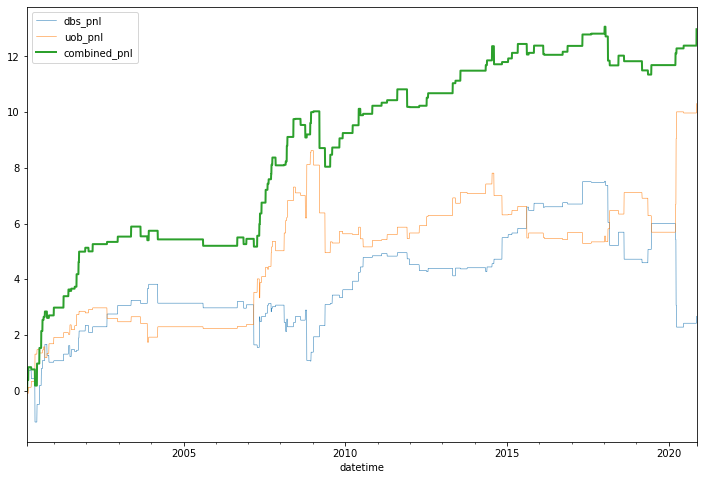

In [63]:
dbs_pnl['net_pnl'].cumsum().plot(label='dbs_pnl', linewidth=0.5)
uob_pnl['net_pnl'].cumsum().plot(label='uob_pnl', linewidth=0.5)
combined_pnl['net_pnl'].cumsum().plot(label='combined_pnl', linewidth=2)
plt.legend()
plt.show()

In [64]:
summary_statistics = bt.calculate_summary_statistics(combined_pnl)

In [65]:
summary_statistics

{'gross_pnl_mean': 0.0017,
 'net_pnl_mean': 0.0017,
 'gross_pnl_sum': 12.98,
 'net_pnl_sum': 12.98,
 'gain_to_pain': 2.3151,
 'adjusted_expectancy': 0.0052}